# Five Applied Econometric Methods for Causal Inference

In [2]:
# Preliminaries

library(dplyr)
library(magrittr)
library(MASS)
library(ggplot2)

set.seed(0)
n <- 10 ^ 3
mu <- matrix(c(0, 0))
rho <- 0.5
sigma1 <- 0.5
sigma2 <- 2
Sigma <- matrix(c(sigma1 ^ 2, 
                  rho * sigma1 * sigma2, 
                  rho * sigma1 * sigma2, 
                  sigma2 ^ 2),
                c(2, 2))

simulatedXandC <- mvrnorm(n = n, mu = mu, Sigma = Sigma)
simulatedError <- rnorm(n = n)
simulatedZ <- round(runif(n))
group <- round(runif(n))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



## Method 1: Controlled Regression

In [3]:
df <- data.frame(X = simulatedXandC[, 1],
                 C = simulatedXandC[, 2],
                 error = simulatedError)
df %<>%
    mutate(Y = 10 + 1 * X + 5 * C + error)

fit <- lm(Y ~ X, data = df)
summary(fit)

fit <- lm(Y ~ X + C, data = df)
summary(fit)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-31.1632  -6.3872  -0.3762   5.8983  29.0409 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.8418     0.2768   35.55   <2e-16 ***
X            10.5451     0.5379   19.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.753 on 998 degrees of freedom
Multiple R-squared:  0.2781,	Adjusted R-squared:  0.2773 
F-statistic: 384.4 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + C, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.14919 -0.64800  0.00176  0.63150  2.96987 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.06880    0.03021  333.26   <2e-16 ***
X            0.95653    0.06748   14.17   <2e-16 ***
C            5.01157    0.01741  287.80   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.955 on 997 degrees of freedom
Multiple R-squared:  0.9914,	Adjusted R-squared:  0.9914 
F-statistic: 5.756e+04 on 2 and 997 DF,  p-value: < 2.2e-16


## Method 2: Regression Discontinuity Design (RDD)

ERROR: Error in library(rdd): there is no package called ‘rdd’


ERROR: Error in eval(expr, envir, enclos): could not find function "RDestimate"



Call:
lm(formula = Y ~ X + C, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.14919 -0.64800  0.00176  0.63150  2.96987 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.06880    0.03021  333.26   <2e-16 ***
X            0.95653    0.06748   14.17   <2e-16 ***
C            5.01157    0.01741  287.80   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.955 on 997 degrees of freedom
Multiple R-squared:  0.9914,	Adjusted R-squared:  0.9914 
F-statistic: 5.756e+04 on 2 and 997 DF,  p-value: < 2.2e-16


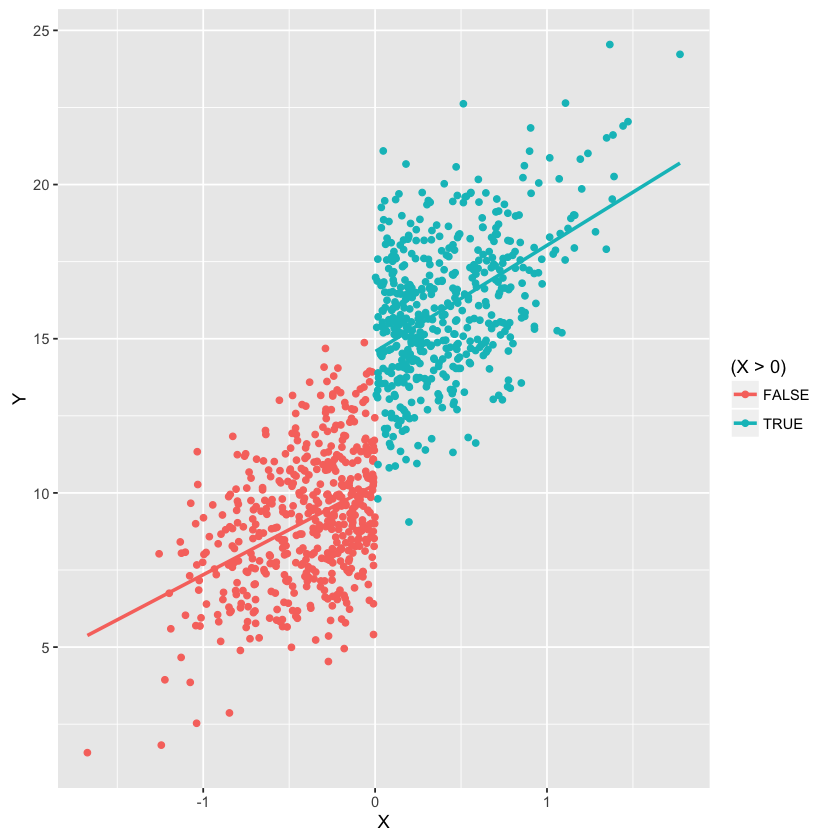

In [4]:
# Regression discontinuity design

library(rdd)

df <- data.frame(X = simulatedXandC[, 1],
                 C = simulatedXandC[, 2],
                 T = (simulatedXandC[, 1] > 0),
                 error = simulatedError)

df %<>%
    mutate(Y = 10 + X ^ 3 + 5 * T + 1 * C + error)

fit <- RDestimate(Y ~ X, data = df)
summary(fit)

ggplot(data = df, aes(x = X, y = Y, color = (X > 0))) + 
    geom_point() +
    geom_smooth(method = lm,   
                se = FALSE)

## Method 3: Difference-in-Differences (DD)

In [5]:
# Difference-in-differences

df <- data.frame(T = 10 * round(runif(n), 1) - 5,
                 G = group,
                 error = simulatedError)

df %<>%
    mutate(Y = 1 - T + 5 * G + 7 * (T >= 0) * G + error)

fit <- lm(Y ~ T + G + I((T >= 0) * G), data = df)
summary(fit)

dfMean <- df %>%
    group_by(T, G) %>%
    summarise(Y = mean(Y))

ggplot(data = df, aes(x = T, y = Y, color = factor(G + 2 * (T >= 0)))) + 
    geom_point() + 
    geom_smooth(method = lm,   
                se = FALSE) + 
    theme(legend.position="none",
          axis.text.x=element_blank(),
          axis.text.y=element_blank()) + 
    scale_color_manual(values=c("#CC6666", "#0072B2", "#CC6666", "#0072B2")) + 
    geom_line(x=-0.5,
              color='black')


Call:
lm(formula = Y ~ T + G + I((T >= 0) * G), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.14303 -0.63898  0.00473  0.62428  2.91457 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.05059    0.04178   25.14   <2e-16 ***
T               -0.99716    0.01302  -76.61   <2e-16 ***
G                5.02352    0.08682   57.86   <2e-16 ***
I((T >= 0) * G)  7.02355    0.11046   63.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9555 on 996 degrees of freedom
Multiple R-squared:  0.9662,	Adjusted R-squared:  0.9661 
F-statistic:  9489 on 3 and 996 DF,  p-value: < 2.2e-16


ERROR: Error in order(data$PANEL, data$group, data$x): argument 3 is not a vector


ERROR: Error in file(con, "rb"): cannot open the connection


ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

## Method 4: Fixed-Effects Regression (FE)

In [6]:
# Fixed-effects regression

df <- data.frame(X = simulatedXandC[, 1],
                 C = round(pmin(2, pmax(-2, simulatedXandC[, 2]))),
                 error = simulatedError)
df %<>%
    mutate(Y = 10 + 1 * X + 5 * C + error)

fit <- lm(Y ~ X, data = df)
summary(fit)

fit <- lm(Y ~ X + factor(C), data = df)
summary(fit)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7123  -5.3978  -0.0537   5.5151  15.2279 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.8147     0.2102   46.69   <2e-16 ***
X             7.7857     0.4084   19.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.647 on 998 degrees of freedom
Multiple R-squared:  0.2669,	Adjusted R-squared:  0.2662 
F-statistic: 363.3 on 1 and 998 DF,  p-value: < 2.2e-16



Call:
lm(formula = Y ~ X + factor(C), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1829 -0.6396  0.0089  0.6546  2.8850 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.03909    0.06508   0.601    0.548    
X            0.95441    0.06668  14.313   <2e-16 ***
factor(C)-1  5.09927    0.09583  53.214   <2e-16 ***
factor(C)0   9.96171    0.09405 105.917   <2e-16 ***
factor(C)1  14.96551    0.10212 146.545   <2e-16 ***
factor(C)2  20.10901    0.09932 202.471   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9546 on 994 degrees of freedom
Multiple R-squared:  0.9849,	Adjusted R-squared:  0.9849 
F-statistic: 1.3e+04 on 5 and 994 DF,  p-value: < 2.2e-16


## Method 5: Instrumental Variables (IV)

In [7]:
# Instrumental variables

df <- data.frame(Z = simulatedZ,   
                 X = simulatedXandC[, 1] + simulatedZ,
                 C = simulatedXandC[, 2],
                 error = simulatedError)
df %<>%
    mutate(Y = 10 + 1.0 * X - 2 * C + error)

# Naive regression produces biased estimates
fit <- lm(Y ~ X, data = df)
summary(fit,  vcov = sandwich)

# IV recovers the underlying model
fit <- ivreg(Y ~ X | Z, data = df)
summary(fit,  vcov = sandwich, df = Inf, diagnostics = TRUE)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.6708  -2.7359   0.0389   2.6774  13.5484 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  11.2014     0.1531  73.165  < 2e-16 ***
X            -1.0045     0.1746  -5.755 1.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.847 on 998 degrees of freedom
Multiple R-squared:  0.03212,	Adjusted R-squared:  0.03115 
F-statistic: 33.11 on 1 and 998 DF,  p-value: 1.155e-08


ERROR: Error in eval(expr, envir, enclos): could not find function "ivreg"



Call:
lm(formula = Y ~ X, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.6708  -2.7359   0.0389   2.6774  13.5484 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  11.2014     0.1531  73.165  < 2e-16 ***
X            -1.0045     0.1746  -5.755 1.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.847 on 998 degrees of freedom
Multiple R-squared:  0.03212,	Adjusted R-squared:  0.03115 
F-statistic: 33.11 on 1 and 998 DF,  p-value: 1.155e-08
